In [1]:
using Rays
using CSV
using DataFrames
using Accessors: @set
using Polynomials

using Random: seed!
seed!(314156);

Rendering options

In [2]:
n_baubels = 400 # max 400
resolution = 1000 # square
color_brightness = 0.75f0
use_dropoff_curve = true
dropoff_power = 1.2

1.2

Load baubel configuration

In [3]:
# Run disks.py first to generate the loaded file
df_disks = CSV.File("disks.csv", types = Float32) |> DataFrame;

Initialize scene and camera

In [4]:
scene = Rays.Scene()
camera = Rays.Camera(; screen_res = (resolution, resolution))
camera = @set camera.dropoff_curve = Rays.ScalarFunc{Float32}(t -> clamp(0.8 - t/5, 0.0f0, 1.0f0))
camera.screen_dist[1] = 0.1f0
from = Float32[1.0, 0.0 , 0.0]
to = zeros(Float32, 3)
Rays.look_at!(camera, from, to)

Compute minimum and maximum baubel distance for dropoff curve

In [5]:
using LinearAlgebra: norm

dist_min = Inf32
dist_max = 0.0f0

n_disks_total = size(df_disks, 1)

x_baubel_scene = zeros(Float32, n_disks_total)
y_baubel_scene = zeros(Float32, n_disks_total)
z_baubel_scene = zeros(Float32, n_disks_total)

for (i,row) in enumerate(eachrow(df_disks))
    x = row.radius
    y = row.center_y - 0.5f0
    z = -(row.center_x - 0.5f0)
    x_baubel_scene[i] = x
    y_baubel_scene[i] = y
    z_baubel_scene[i] = z
    loc_baubel = Float32[x,y,z]
    dist = norm(camera.loc - loc_baubel) - row.radius - camera.screen_dist[1]
    dist_min = min(dist_min, dist)
    dist_max = max(dist_max, dist)
end

df_disks[!, :x_baubel_scene] = x_baubel_scene;
df_disks[!, :y_baubel_scene] = y_baubel_scene;
df_disks[!, :z_baubel_scene] = z_baubel_scene;

@show dist_min
@show dist_max;

dist_min = 0.86810166f0
dist_max = 1.0186492f0


In [6]:
if use_dropoff_curve
    camera = @set camera.dropoff_curve = Rays.ScalarFunc{Float32}(t -> dist_min <= t <= dist_max ? ((dist_max-t)/(dist_max-dist_min))^dropoff_power : 0.0f0)
end
push!(scene, camera);

Define baubel textures

In [7]:
using Combinatorics: combinations

red = color_brightness * Float32[1, 0, 0]
green = color_brightness * Float32[0, 0.4, 0.2]
purple = color_brightness * Float32[0.5, 0, 0.5]
colors = [red, green, purple]

function colorfield_1!(color::AbstractVector{Float32}, loc_int::AbstractVector{Float32},
    color_1::AbstractVector{Float32}, color_2::AbstractVector{Float32}, n_repetitions::Int)::Nothing
    θ = atan(loc_int[3], loc_int[2])
    ϕ = asin(loc_int[1]/norm(loc_int))
    n_colors = 2
    index1 = Int(floor(mod(n_repetitions*n_colors*θ/2π, n_colors)))
    index2 = Int(floor(mod(n_repetitions*n_colors*ϕ/2π, n_colors)))
    index = mod(index1 + index2, 2)
    color .= index == 0 ? color_1 : color_2
    return nothing
end

function colorfield_2!(color::AbstractVector{Float32}, loc_int::AbstractVector{Float32},
    color_1::AbstractVector{Float32}, color_2::AbstractVector{Float32}, n_repetitions::Int)::Nothing
    θ = atan(loc_int[3], loc_int[2])
    ϕ = asin(loc_int[1]/norm(loc_int))
    λ = ϕ + (θ - π)
    μ = ϕ - (θ - π)
    n_colors = 2
    index1 = Int(floor(mod(n_repetitions*n_colors*λ/2π, n_colors)))
    index2 = Int(floor(mod(n_repetitions*n_colors*μ/2π, n_colors)))
    index = mod(index1 + index2, 2)
    color .= index == 0 ? color_1 : color_2
    return nothing
end

function colorfield_3!(color::AbstractVector{Float32}, loc_int::AbstractVector{Float32},
    color_1::AbstractVector{Float32}, color_2::AbstractVector{Float32}, n_repetitions::Int)::Nothing
    θ = atan(loc_int[3], loc_int[2])
    n_colors = 2
    index = Int(floor(mod(n_repetitions*n_colors*θ/2π, n_colors)))
    color .= index == 0 ? color_1 : color_2
    return nothing
end

baubel_textures = Rays.Texture{Float32}[]
for color in colors
    push!(baubel_textures, Rays.UniformTexture(color))
end

for color_set in combinations(colors, 2)
    for colorfield! in [colorfield_1!, colorfield_2!, colorfield_3!]
        for n_repetitions in [4,5,6]
            push!(
                baubel_textures, 
                Rays.ColorFieldTexture(
                    (color, loc_int) -> 
                        colorfield!(color, loc_int, color_set[1], color_set[2], n_repetitions)
                )
            )
        end
    end
end

Baubel adding function

In [9]:
gold = color_brightness * Float32[0.99, 0.9, 0.2]
gold_texture = Rays.UniformTexture(gold)

function add_baubel!(scene::Rays.Scene, center::Vector{Float32}, radius::Float32)::Nothing
    main_sphere = Rays.Sphere(radius)
    main_sphere = @set main_sphere.name = :baubel_main_sphere
    θ = 2π*rand()
    ϕ = Float32(π/3 * rand() - π/6) 
    rotation = Rays.rotation(Float32[0, cos(θ), sin(θ)], ϕ)
    translation = Rays.translation(center) 
    main_transform = translation ∘ rotation
    main_texture = baubel_textures[rand(1:end)]
    push!(scene, main_sphere; transform = main_transform, texture = main_texture)

    top_sphere = Rays.Sphere(0.003f0)
    top_sphere = @set top_sphere.name = :baubel_top
    top_transform = main_transform ∘ Rays.translation(Float32[radius, 0, 0])
    push!(scene, top_sphere; transform = top_transform, texture = gold_texture)
    return nothing
end

add_baubel! (generic function with 1 method)

Limit the amount of baubels rendered (for testing purposes)

In [10]:
df_disks = df_disks[1:n_baubels, :]

Row,center_x,center_y,radius,x_baubel_scene,y_baubel_scene,z_baubel_scene
,Float32,Float32,Float32,Float32,Float32,Float32
1,0.22,0.466,0.016,0.016,-0.034,0.28
2,0.506,0.442,0.016,0.016,-0.058,-0.00599998
3,0.49,0.584,0.016,0.016,0.084,0.00999999
4,0.312,0.33,0.016,0.016,-0.17,0.188
5,0.318,0.47,0.016,0.016,-0.03,0.182
6,0.484,0.45,0.006,0.006,-0.05,0.016
7,0.178,0.358,0.016,0.016,-0.142,0.322
8,0.776,0.672,0.016,0.016,0.172,-0.276
9,0.242,0.41,0.016,0.016,-0.09,0.258


Add baubels to scene

In [11]:
for row in eachrow(df_disks)
    add_baubel!(scene, Float32[row.x_baubel_scene, row.y_baubel_scene, row.z_baubel_scene], row.radius)
end

Add background to scene

In [12]:
using Images: load, channelview

R = 0.5f0
background = Rays.Cube(R)
transform = Rays.translation(Float32[-R,0,0])
# Source: https://pxhere.com/en/photo/741548
snow_image = channelview(load("snow.jpg"))
function snow!(color::AbstractVector{Float32}, loc_int::AbstractVector{Float32})::Nothing
    color .= snow_image[:, 
        1 + Int(round(1439 * (loc_int[3]+0.5f0))), 
        1 + Int(round(1439 * (loc_int[2]+0.5f0)))
    ][3]
    return nothing
end
texture = Rays.ColorFieldTexture(snow!)
push!(scene, background; transform, texture);

Render and show result

In [13]:
Rays.partition!(scene)
Rays.render!(scene)

In [14]:
using Images: colorview, RGB, N0f8

function view_canvas(camera)
    canvas_RGB = RGB{N0f8}.([view(camera.canvas, channel, :, :) for channel = 1:3]...)
    colorview(RGB, canvas_RGB)
end

view_canvas (generic function with 1 method)

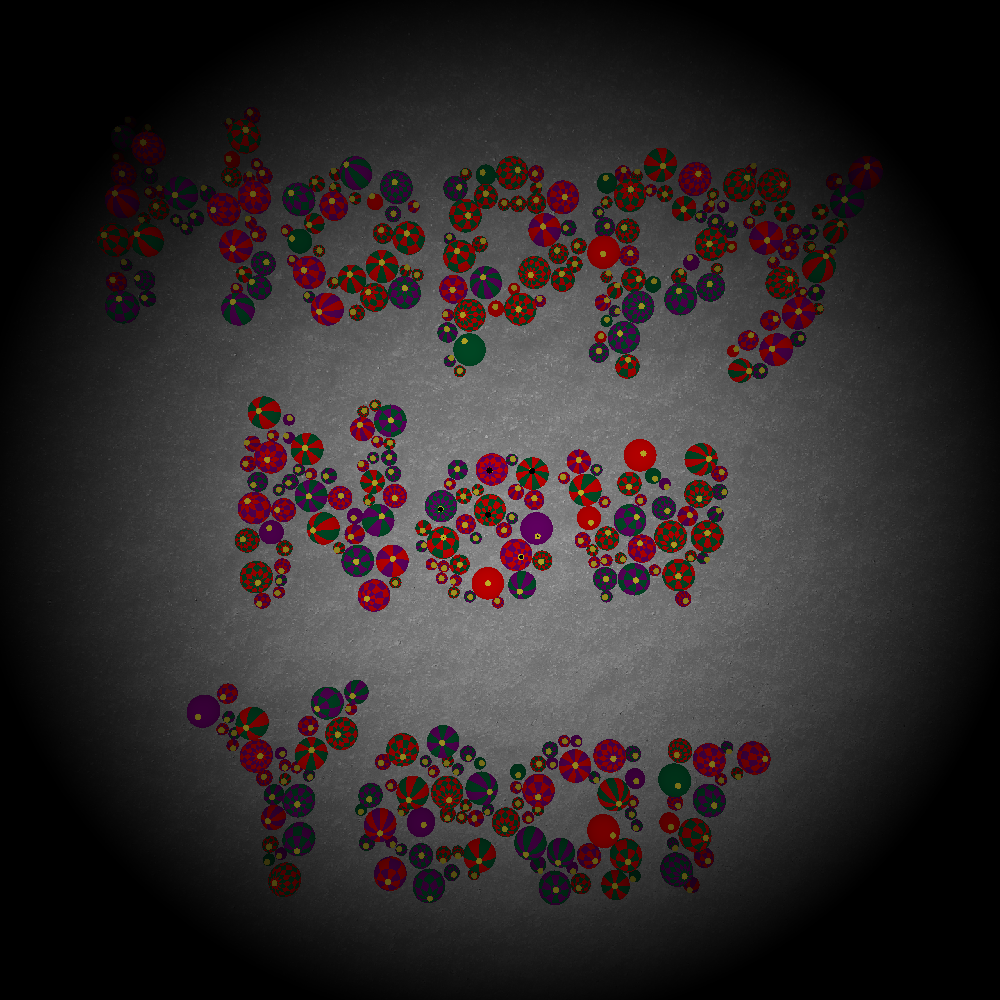

In [15]:
view_canvas(camera)

Save result

In [16]:
using Images: save 
canvas_RGB = RGB{N0f8}.([view(camera.canvas, channel, :, :) for channel = 1:3]...)
save("Happy_New_Year_$resolution.png", canvas_RGB)